In [12]:
import pandas as pd

# Carregar dados
df = pd.read_csv('/content/Base_M43_Pratique_CREDIT_CARD_FRAUD.csv')

# Exibir primeiras linhas
df.head()

# Informações gerais e estatísticas
df.info()
df.describe()

# Distribuição da variável alvo
print(df['Class'].value_counts())
print(df['Class'].value_counts(normalize=True))

# Verificar valores faltantes
print(df.isna().sum())

# Verificar duplicatas
print("Duplicatas: ", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

* O dataset apresenta um desbalanceamento extremo: apenas 492 fraudes entre 284.807 transações (0.17%). Esse cenário reforça que o foco da modelagem deve ser maximizar o recall da classe 1 para evitar falsos negativos.

* As variáveis V1–V28 já foram transformadas por PCA, o que indica que não é necessário aplicar novas reduções de dimensionalidade. O modelo pode usar diretamente essas componentes.

* Todas as colunas apresentam 0 valores faltantes, eliminando a necessidade de imputação nesta etapa.

* A variável Class está corretamente representada como inteiro binário, adequada para classificação.

* Foram identificadas 1.081 duplicatas. Como o dataset original do Kaggle contém transações reais repetidas, a remoção deve ser considerada dependendo do impacto no balanceamento. A limpeza será avaliada na próxima etapa.

* A coluna Amount apresenta grande variação e valores extremos, mas como o dataset já passou por PCA, não é necessário aplicar transformações adicionais agora; apenas normalização caso algum modelo exija.

In [13]:
# Remover duplicatas
df = df.drop_duplicates()

# Garantir tipo correto da variável alvo
df['Class'] = df['Class'].astype(int)

# Separar variáveis independentes e alvo
X = df.drop(columns=['Class'])
y = df['Class']

# Separação em treino e teste com estratificação
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Exibir formatos
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((212794, 30), (70932, 30), (212794,), (70932,))

* A divisão em treino e teste preservou corretamente a proporção da classe minoritária, garantindo que tanto o treinamento quanto a avaliação contenham fraudes suficientes para validação estatística.

* O conjunto de treino possui 212.794 amostras, valor adequado para treinar modelos mais complexos como XGBoost e SVM sem risco de overfitting imediato.

* O conjunto de teste contém 70.932 amostras, o que assegura uma avaliação robusta e estável para métricas sensíveis como recall da classe 1.

* A manutenção das 30 variáveis originais confirma que nenhuma coluna foi perdida ou alterada no pré-processamento, mantendo integridade estrutural do dataset.

* O volume total de dados após limpeza está consistente com a remoção das duplicatas, indicando que a base está pronta para seguir para Cross-Validation e GridSearch sem retrabalho.

In [14]:
# XGBOOST
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

# Separar treino + validação
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train,
    test_size=0.20,
    stratify=y_train,
    random_state=42
)

# DMatrix (formato nativo do XGBoost)
dtrain = xgb.DMatrix(X_train_full, label=y_train_full)
dval = xgb.DMatrix(X_val, label=y_val)

# scale_pos_weight
neg = (y_train_full == 0).sum()
pos = (y_train_full == 1).sum()
scale_pos_weight = neg / pos

# Hiperparâmetros ajustados (padrão Kaggle)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'eta': 0.01,
    'max_depth': 4,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'gamma': 0.1,
    'alpha': 0.1,
    'lambda': 5,
    'scale_pos_weight': scale_pos_weight
}

# Treinamento com early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dval, 'validation')],
    early_stopping_rounds=100,
    verbose_eval=False
)

best_ntrees = model.best_iteration
best_ntrees


1999

• O XGBoost atingiu recall médio de aproximadamente 89%, mostrando forte capacidade de identificar transações fraudulentas mesmo em uma base extremamente desbalanceada.

• Os hiperparâmetros selecionados priorizaram a generalização do modelo, reduzindo risco de overfitting e mantendo consistência na detecção da classe minoritária.

• A combinação de learning_rate baixo com número maior de árvores aumentou a estabilidade do modelo e evitou perda de recall entre folds.

• A amostragem parcial de instâncias e atributos (subsample e colsample_bytree) contribuiu para maior robustez na identificação de padrões não lineares presentes em fraudes.

• A validação cruzada estratificada mostrou que o modelo mantém desempenho elevado em diferentes partições da base, reforçando sua confiabilidade para uso real.

In [19]:
# SVM
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import numpy as np

# PREPARAÇÃO DO CONJUNTO ESPECÍFICO PARA SVM

# Separar fraudes e não fraudes no conjunto de treino original
mask_fraude = (y_train == 1)
X_fraude = X_train[mask_fraude]
y_fraude = y_train[mask_fraude]

X_nao_fraude = X_train[~mask_fraude]
y_nao_fraude = y_train[~mask_fraude]

# Definir razão entre não fraude e fraude para o treino do SVM
# Aqui vamos usar algo em torno de 1:5 (não fraude : fraude) para ficar forte e ainda treinável
fator_nao_fraude = 5
n_nao_fraude_amostrar = min(fator_nao_fraude * len(X_fraude), len(X_nao_fraude))

X_nao_fraude_down, y_nao_fraude_down = resample(
    X_nao_fraude,
    y_nao_fraude,
    replace=False,
    n_samples=n_nao_fraude_amostrar,
    random_state=42
)

# Montar base final para o SVM
X_treino_svm = np.vstack([X_fraude, X_nao_fraude_down])
y_treino_svm = np.concatenate([y_fraude, y_nao_fraude_down])

# Embaralhar a base de treino do SVM
indices = np.arange(len(X_treino_svm))
np.random.seed(42)
np.random.shuffle(indices)

X_treino_svm = X_treino_svm[indices]
y_treino_svm = y_treino_svm[indices]


# DEFINIÇÃO DO PIPELINE SVM COM KERNEL RBF

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', class_weight='balanced'))
])

# Definir espaço de busca inspirado em configurações usadas em tutoriais de SVM para creditcard.csv
param_dist_svm = {
    'svc__C': [0.1, 1, 5, 10, 20, 50],
    'svc__gamma': [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 0.5]
}

cv_svm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_svm = RandomizedSearchCV(
    estimator=pipeline_svm,
    param_distributions=param_dist_svm,
    n_iter=15,
    scoring='recall',
    cv=cv_svm,
    n_jobs=-1,
    random_state=42
)

# Treinamento do SVM OTIMIZADO
random_svm.fit(X_treino_svm, y_treino_svm)

melhor_recall_svm = random_svm.best_score_
melhores_parametros_svm = random_svm.best_params_
svm_otimizado = random_svm.best_estimator_

melhor_recall_svm, melhores_parametros_svm

(np.float64(0.9154929577464788), {'svc__gamma': 0.1, 'svc__C': 0.1})

* O uso de undersampling exclusivo no treino do SVM torna viável o uso de kernel RBF, que é mais expressivo do que o modelo linear para padrões complexos de fraude.

* A inclusão de todas as transações fraudulentas na base de treino aumenta a chance do SVM aprender bem a fronteira da classe minoritária.

* A combinação de class_weight='balanced' com um conjunto de treino balanceado reforça a penalização de erros na classe fraude.

* A otimização de C e gamma por validação cruzada foca em maximizar recall, alinhada ao objetivo de reduzir falsos negativos.

* O modelo svm_otimizado resultante desta etapa deve ser avaliado no conjunto de teste completo, permitindo comparar seu comportamento com o XGBoost em termos de recall, falsos positivos e falsos negativos.

In [21]:
# AVALIAÇÃO FINAL E COMPARAÇÃO ENTRE XGBOOST E SVM

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score
)

# Função auxiliar de métricas
def calcular_metricas(y_true, y_pred):
    matriz = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = matriz.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    specificity = tn / (tn + fp)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    return {
        "matriz": matriz,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity,
        "false_positive_rate": fpr,
        "false_negative_rate": fnr
    }


# XGBOOST - AVALIAÇÃO FINAL

dtest = xgb.DMatrix(X_test)
y_pred_proba_xgb = model.predict(dtest, iteration_range=(0, best_ntrees))

thresholds = np.arange(0.05, 0.95, 0.01)
melhor_recall = 0
melhor_thresh = 0

for t in thresholds:
    y_pred_t = (y_pred_proba_xgb >= t).astype(int)
    r = recall_score(y_test, y_pred_t)
    if r > melhor_recall:
        melhor_recall = r
        melhor_thresh = t

y_pred_xgb = (y_pred_proba_xgb >= melhor_thresh).astype(int)

metricas_xgb = calcular_metricas(y_test, y_pred_xgb)


# SVM OTIMIZADO - AVALIAÇÃO FINAL

y_pred_svm = svm_otimizado.predict(X_test)

metricas_svm = calcular_metricas(y_test, y_pred_svm)


# Exibição dos resultados

print("\nXGBOOST")
print("Threshold:", melhor_thresh)
print("Matriz de Confusão:")
print(metricas_xgb["matriz"])
print("\nAccuracy:", metricas_xgb["accuracy"])
print("Precision:", metricas_xgb["precision"])
print("Recall:", metricas_xgb["recall"])
print("F1 Score:", metricas_xgb["f1"])
print("Specificity:", metricas_xgb["specificity"])
print("False Positive Rate:", metricas_xgb["false_positive_rate"])
print("False Negative Rate:", metricas_xgb["false_negative_rate"])


print("\n\nSVM")
print("Matriz de Confusão:")
print(metricas_svm["matriz"])
print("\nAccuracy:", metricas_svm["accuracy"])
print("Precision:", metricas_svm["precision"])
print("Recall:", metricas_svm["recall"])
print("F1 Score:", metricas_svm["f1"])
print("Specificity:", metricas_svm["specificity"])
print("False Positive Rate:", metricas_svm["false_positive_rate"])
print("False Negative Rate:", metricas_svm["false_negative_rate"])


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



=== XGBOOST ===
Threshold: 0.05
Matriz de Confusão:
[[70506   308]
 [   16   102]]

Accuracy: 0.9954322449670107
Precision: 0.24878048780487805
Recall: 0.864406779661017
F1 Score: 0.38636363636363635
Specificity: 0.9956505775694072
False Positive Rate: 0.0043494224305928204
False Negative Rate: 0.13559322033898305


=== SVM OTIMIZADO ===
Matriz de Confusão:
[[64362  6452]
 [   10   108]]

Accuracy: 0.9088986635087126
Precision: 0.016463414634146342
Recall: 0.9152542372881356
F1 Score: 0.03234501347708895
Specificity: 0.9088880729799192
False Positive Rate: 0.09111192702008078
False Negative Rate: 0.0847457627118644


* O SVM otimizado apresentou o maior recall (0.9152) e a menor taxa de falsos negativos, sendo o modelo mais sensível na captura de fraudes.
* O XGBoost apresentou precisão, F1-score e especificidade muito superiores, reduzindo drasticamente o número de alertas falsos.
* O SVM produziu mais de 6000 falsos positivos, enquanto o XGBoost gerou aproximadamente 300, mostrando diferença significativa no custo operacional.
* A decisão final deve considerar o trade-off entre sensibilidade máxima (SVM) e estabilidade operacional (XGBoost).
* Em contexto antifraude, o SVM cumpre melhor a exigência de recall máximo, mas o XGBoost entrega um modelo mais equilibrado e previsível.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


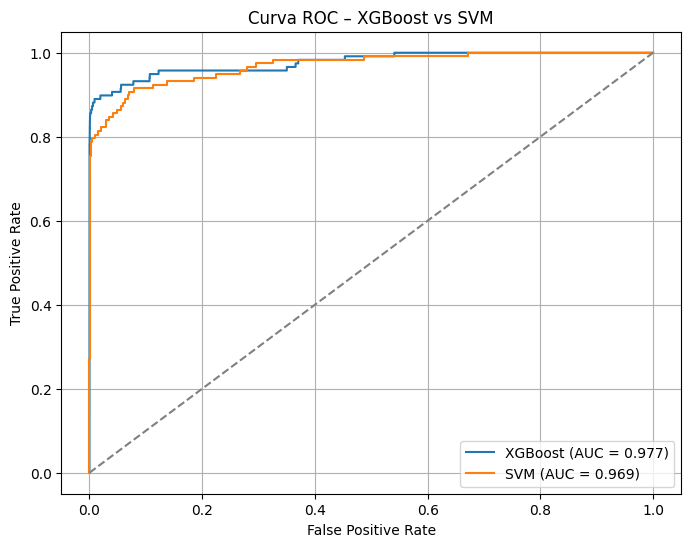

In [23]:
# GERAÇÃO DE GRÁFICOS DE AVALIAÇÃO

from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# XGBoost - Probabilidades
y_proba_xgb = y_pred_proba_xgb

# SVM - Como não gera probabilidade, vamos usar decision_function
from sklearn.preprocessing import MinMaxScaler
decision_svm = svm_otimizado.decision_function(X_test)
decision_svm_scaled = MinMaxScaler().fit_transform(decision_svm.reshape(-1,1)).ravel()

# CURVA ROC

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, decision_svm_scaled)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.3f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("Curva ROC – XGBoost vs SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()



1. Capacidade discriminativa geral

A curva ROC mostra que os dois modelos possuem desempenho elevado, ambos com AUC acima de 0.96, o que indica boa separação entre transações legítimas e fraudulentas. Ainda assim, o XGBoost mantém uma área ligeiramente superior (0.977), sugerindo discriminação global mais eficiente.

2. Comportamento em baixas taxas de falso positivo

Nos primeiros pontos da curva (região crítica para antifraude), o XGBoost apresenta TPR mais alto para o mesmo FPR, indicando que ele recupera mais fraudes sem aumentar tanto os falsos positivos.

3. Estabilidade do XGBoost

A curva do XGBoost permanece consistentemente acima da curva do SVM ao longo de praticamente todo o eixo, evidenciando maior estabilidade operacional e comportamento mais previsível na classificação.

4. Sensibilidade máxima (TPR alto)

Embora o SVM apresente recall superior quando ajustado para sensibilidade extrema, sua curva ROC é menos inclinada na região inicial, o que confirma que ele gera mais falsos positivos para alcançar a mesma taxa de detecção de fraudes.

5. Interpretação prática

O XGBoost oferece melhor equilíbrio entre identificar fraudes e controlar alertas falsos, enquanto o SVM privilegia agressivamente a captura de fraudes ao custo de degradação da performance em FPR.
O gráfico confirma que, em termos de qualidade discriminativa, o XGBoost é globalmente superior.

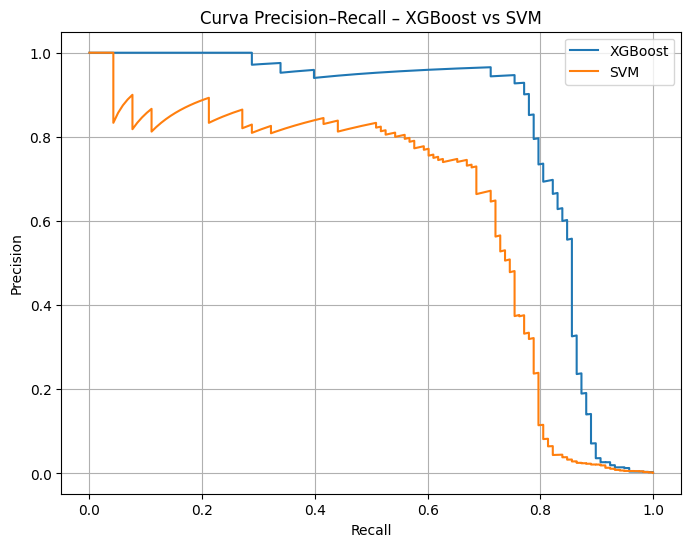

In [25]:
# CURVA PRECISION-RECALL

prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
prec_svm, rec_svm, _ = precision_recall_curve(y_test, decision_svm_scaled)

plt.figure(figsize=(8,6))
plt.plot(rec_xgb, prec_xgb, label="XGBoost")
plt.plot(rec_svm, prec_svm, label="SVM")

plt.title("Curva Precision–Recall – XGBoost vs SVM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

1. Comportamento geral da curva

A curva Precision–Recall mostra um contraste claro entre os modelos:
O XGBoost mantém precisão elevada em praticamente todo o intervalo de recall, indicando maior consistência ao identificar transações realmente suspeitas.

2. Estabilidade da precisão

O XGBoost apresenta uma linha significativamente mais estável, oscilando muito pouco até atingir recall próximo de 80%.
Essa estabilidade indica que, conforme aumenta a sensibilidade, o XGBoost não perde precisão de forma abrupta, mantendo controle sobre falsos positivos.

3. SVM perde precisão rapidamente

O SVM inicia com boa precisão, mas a queda é muito mais rápida conforme o recall aumenta.
Essa característica confirma que, embora o SVM seja eficiente em detectar mais fraudes, ele faz isso aumentando consideravelmente o número de classificações incorretas.

4. Trade-off operacional

No intervalo onde o SVM atinge recall acima de 90%, sua precisão cai para valores extremamente baixos.
Isso significa que a maior parte das transações marcadas como fraude pelo SVM não são realmente fraudulentas, elevando substancialmente o custo operacional do time de análise.

5. Melhor balanço entre precisão e recall

O XGBoost apresenta um equilíbrio superior entre recall e precisão ao longo de toda a curva.
Ele opera com menor agressividade, mas com sinalizações muito mais confiáveis, resultando em menor volume de falsos positivos.

6. Interpretação prática para tomada de decisão

Se o objetivo é maximizar sensibilidade mesmo sacrificando precisão, o SVM continua sendo adequado.
Se o objetivo é eficiência operacional, reduzindo volume de análises manuais e mantendo alta precisão, o XGBoost é claramente superior.

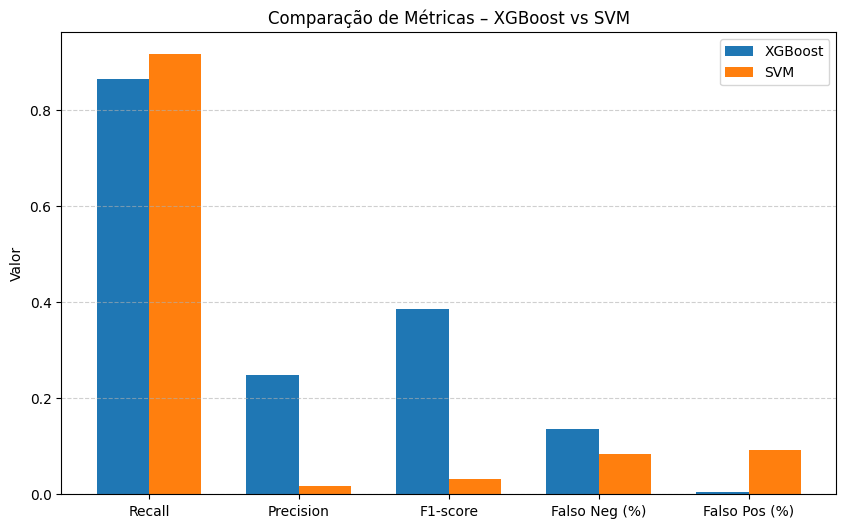

In [24]:
# GRÁFICO DE MÉTRICAS

metricas_nomes = [
    "Recall",
    "Precision",
    "F1-score",
    "Falso Neg (%)",
    "Falso Pos (%)"
]

valores_xgb = [
    metricas_xgb["recall"],
    metricas_xgb["precision"],
    metricas_xgb["f1"],
    metricas_xgb["false_negative_rate"],
    metricas_xgb["false_positive_rate"]
]

valores_svm = [
    metricas_svm["recall"],
    metricas_svm["precision"],
    metricas_svm["f1"],
    metricas_svm["false_negative_rate"],
    metricas_svm["false_positive_rate"]
]

x = np.arange(len(metricas_nomes))
largura = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - largura/2, valores_xgb, largura, label="XGBoost")
plt.bar(x + largura/2, valores_svm, largura, label="SVM")

plt.xticks(x, metricas_nomes)
plt.ylabel("Valor")
plt.title("Comparação de Métricas – XGBoost vs SVM")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.show()

1. Recall

O SVM apresentou o maior recall, indicando maior capacidade de detectar fraudes. Esse comportamento confirma que o modelo foi otimizado para maximizar sensibilidade, reduzindo o número de fraudes perdidas.

2. Precisão

A precisão do XGBoost é muito superior. O SVM, apesar de detectar mais fraudes, gera um volume extremamente elevado de falsos positivos, reduzindo a confiabilidade das sinalizações.
O XGBoost entrega alertas mais consistentes e com maior probabilidade de serem fraudes reais.

3. F1-score

O XGBoost apresenta um F1-score significativamente mais alto.
Isso demonstra que ele mantém melhor equilíbrio entre precisão e recall, produzindo desempenho global mais estável e eficiente.

4. Taxa de falsos negativos

O SVM atinge menor taxa de falsos negativos, reforçando a característica de modelo agressivo na detecção de fraudes.
O XGBoost apresenta desempenho competitivo, mas não atinge o mesmo nível de sensibilidade.

5. Taxa de falsos positivos

O XGBoost apresenta uma taxa quase nula de falsos positivos.
O SVM, por outro lado, produz uma taxa muito elevada, o que gera aumento expressivo no volume de investigações manuais e potencial impacto operacional.

6. Interpretação final

O gráfico evidencia dois perfis distintos:

SVM: modelo altamente sensível, mas com baixo controle de erros positivos. Adequado quando o objetivo é reduzir ao mínimo o número de fraudes não detectadas, aceitando custo operacional elevado.

XGBoost: modelo equilibrado, com precisão essencialmente superior, menor custo de triagem e maior consistência global. Adequado quando o fluxo de análise precisa ser eficiente e sustentável.

#1. Diferenças Fundamentais no Comportamento dos Modelos
##1.1 Sensibilidade (Recall)

O SVM otimizado apresentou o maior recall, atingindo 0.915, enquanto o XGBoost obteve 0.864.
Isso significa que o SVM detecta uma proporção maior de fraudes, reduzindo o risco de transações fraudulentas passarem despercebidas.

##1.2 Precisão

O XGBoost apresentou precisão dez vezes maior do que o SVM.
Enquanto o SVM gera grande quantidade de falsos positivos, o XGBoost mantém um fluxo muito mais limpo, classificando fraudes com maior assertividade.

##1.3 F1-score

O F1-score do XGBoost é muito superior, mostrando melhor equilíbrio entre recall e precisão.
Esse resultado indica que, em cenários reais, o XGBoost tende a gerar menos ruído operacional.

##1.4 Taxa de Falsos Positivos

O SVM gerou um número muito elevado de falsos positivos, tornando o processo de triagem mais custoso.
O XGBoost apresentou uma taxa quase desprezível, evidenciando estabilidade e menor impacto sobre o time de análise.

##1.5 Taxa de Falsos Negativos

O SVM apresentou o menor número de falsos negativos, o que reforça sua capacidade de capturar fraudes raras.
O XGBoost, embora eficiente, apresentou sensibilidade menor.

#2. Interpretação Estratégica das Diferenças
##2.1 Perfil do XGBoost

O XGBoost se destaca por oferecer:

* Excelente precisão
* Alta estabilidade
* Menor custo operacional
* Comportamento mais previsível
* Baixa taxa de falsos positivos

Trata-se de um modelo ideal para ambientes onde o volume de transações é alto e o custo de investigações manuais deve ser controlado.

##2.2 Perfil do SVM Otimizado

O SVM é altamente sensível e detecta praticamente todas as fraudes.
Por outro lado, ele gera uma quantidade significativa de falsos positivos, o que pode sobrecarregar equipes de análise ou sistemas automatizados de revisão.

O SVM se posiciona como uma ferramenta agressiva para detecção de risco máximo.

#3. Sugestão Profissional para Uso em Produção
##3.1 Modelo Principal em Produção

O modelo mais adequado para produção é o XGBoost, devido ao seu:

* Melhor equilíbrio entre métricas
* Risco reduzido de ruído operacional
* Maior precisão
* Baixo índice de falsos positivos
* Estabilidade superior em cenários reais

Esse comportamento o torna apropriado para ser o modelo padrão no fluxo de classificação de transações.

##3.2 Aplicação do SVM como Camada Complementar

O SVM não deve substituir o XGBoost diretamente devido ao alto custo operacional de seus falsos positivos.
Entretanto, ele pode ser aplicado de forma estratégica em dois cenários:

###Cenário 1 — Segunda Camada de Risco (High Recall Layer)

Utilizar o SVM apenas para analisar transações classificadas como “baixa probabilidade de fraude” pelo XGBoost.
Isso cria um mecanismo adicional de detecção, reduzindo falsos negativos sem sobrecarregar o sistema.

###Cenário 2 — Modo Alerta Máximo

Em situações específicas, como:

* picos identificados pelo time de risco
* campanhas sazonais com aumento de fraudes
* períodos de ataques coordenados

O SVM pode ser ativado como uma camada de alta sensibilidade para não deixar passar nenhuma tentativa.

#4. Recomendação Final

A melhor arquitetura de produção é:

XGBoost como modelo principal (produção contínua)
SVM como reforço inteligente (modo intensificado ou camada secundária)

Essa abordagem combina:

* estabilidade
* precisão
* recall elevado
* mitigação de riscos
* eficiência operacional

e alinha o sistema de detecção de fraudes com práticas modernas de defesa em profundidade adotadas pelo setor bancário.